In [1]:
# https://github.com/kurmukovai/ebm-progression
    
# https://github.com/EuroPOND/ebm
    
# https://github.com/ucl-pond/ebm
        
# https://github.com/88vikram/pyebm/



# TODO: multiply shortest distance matrix (multiply distance matrix (priors) by lambda)

# 1. Clean up code (new notebook)
# 2. Remove first biomarker and first row/column of prior matrix
# 3. Compute spearman's rank correlation between true (1,2,3..10) and mcmc-optimal order
# 4. Compare spearman's rho for when using and when not using prior
# 5. Implement hyperparameter lambda to multiply prior matrix
# 6. Make a graph of spearman's rho vs. value of lambda (vary lambda over large magnitude ranges, e.g. from 10^-5 to 10^5)

---

$$
\frac{a}{b+f*e^{(-x+c)/d}}
$$

- a - вытягивает/сжимает сигмоиду по оси OY (не нужен)
- b - сжимает/вытягивает сигмоиду по оси OY (не нужен)
- f - немного двигает по оси OX (хуже чем `c`, не нужен)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from scipy.linalg import fractional_matrix_power
%matplotlib inline

An event-based model for disease progression and its application in familial
Alzheimer's disease and Huntington's disease, Fonteijn et. al, 2012

[1] https://pure.mpg.de/rest/items/item_1313588/component/file_1402624/content

Model assumptions


1. All patients have the same order of biomarkers degeneration
2. Biomarkers degenerate monotonically (once degenerate - never recover)
3. A specific biomarker distribution could be modelled as:
    - mixture of gaussians (healthy, diseased)
    - mixture of gaussian and uniform
4. Degradation trajectory follows a sigmoid with individual (for every biomarker) parameters of shift and slope:


$$
y = 1 - \frac{1}{1+e^{-(x-\text{shift})/\text{slope}}}
$$

# 1. Connectivity Matrix Model

We model Alzheimer's disease (AD) biomarker progression through a connectivity matrix, capturing the intricate relationships between various biomarkers. This approach utilizes a transition matrix to simulate how each biomarker's progression influences and is influenced by other biomarkers over time.

## Transition Matrix

The transition matrix, \(A\), is central to our model. It dictates the progression rates and interactions between biomarkers. The matrix is structured as follows, where \(coeff\) represents the interaction strength between adjacent biomarkers:

$$
A = 
\begin{pmatrix}
1 & coeff & 0 & \cdots & 0 \\
coeff & 1 & coeff & \ddots & \vdots \\
0 & coeff & 1 & \ddots & 0 \\
\vdots & \ddots & \ddots & \ddots & coeff \\
0 & \cdots & 0 & coeff & 1 \\
\end{pmatrix}
$$

- **Diagonal elements** are set to $1$, indicating the baseline progression rate of each biomarker.
- **Off-diagonal elements** adjacent to the diagonal are set to coeff, representing the influence between neighboring biomarkers.

This symmetric matrix defines bidirectional brain connections.

## Model Implementation

The model's implementation involves the following key functions:

- `generate_transition_matrix(size, coeff)`: Generates the symmetric transition matrix $A$ based on the specified size and coefficient.
- `initialize_biomarkers(num_biomarkers, init_value)`: Initializes the biomarker values, setting the first biomarker to a starting value and the rest to $1.0$.
- `apply_transition_matrix(A, n, y_init)`: Applies the transition matrix $A$ over $n$ stages to simulate the progression of biomarkers from their initial state $y_{init}$
- `simulate_progression_over_stages(transition_matrix, stages, y_init)`: Uses the transition matrix to simulate the progression of all biomarkers over multiple specified stages.

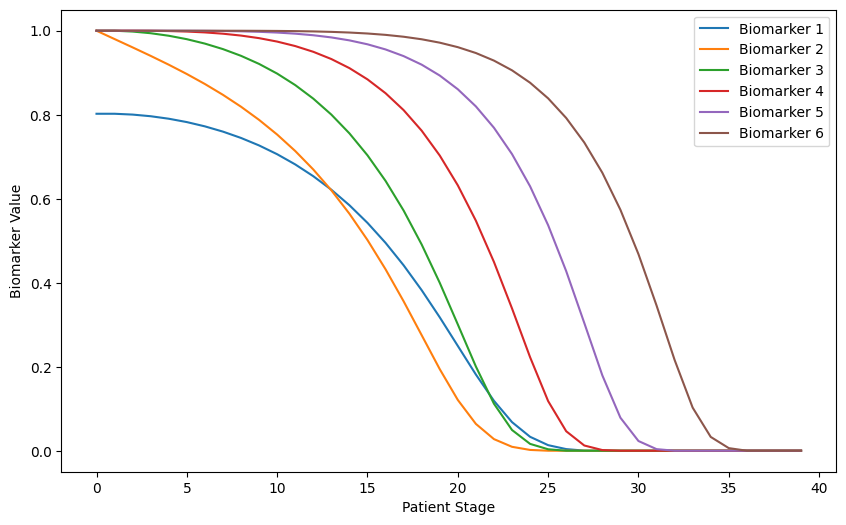

In [3]:
def generate_transition_matrix(size, coeff):
    """Generates a symmetric transition matrix with coefficient decay off-diagonal."""
    A = np.eye(size)
    np.fill_diagonal(A[:-1, 1:], coeff)
    np.fill_diagonal(A[1:, :-1], coeff)
    return A.astype(np.float32)

def initialize_biomarkers(num_biomarkers, init_value=0.9):
    """Initializes biomarkers with a fixed initial value for the first biomarker."""
    y = np.full(num_biomarkers, 1, dtype=np.float32)
    y[0] = init_value
    return y

def apply_transition_matrix(A, n, y_init):
    """Applies the transition matrix to simulate biomarker progression for n stages."""
    y = np.clip(A @ (1 - y_init), 0, 1)
    for _ in range(1, n):
        y = np.clip(A @ y, 0, 1)
    return 1 - y

def softplus(x): # added in to smooth the biomarker curves
    return np.log(1.0+np.exp(x))

def apply_transition_matrix2(A, n, y_init, alpha = 10, delta = 0.5):

    y = 1 - y_init 
    if(len(np.shape(n)) == 0):
        y_out = np.clip(fractional_matrix_power(A,n)@y,0,1)
      
    else:
        y_out = np.full([np.shape(y)[0],np.shape(n)[0]],1.0)
        for s,j in zip(n,range(len(n))):
            y_out[:,j] = np.clip(fractional_matrix_power(A,s)@y,0,1)
    y = 1 - y_out   
    
    y = softplus(alpha*(y-delta)) / softplus(alpha*(1.0-delta))
              
    return y

def simulate_progression_over_stages(transition_matrix, stages, y_init):
    """Simulates the progression of biomarker values over multiple stages."""
    return np.array([apply_transition_matrix(transition_matrix, stage, y_init) for stage in stages])

def simulate_progression_over_stages2(transition_matrix, stages, y_init):
    """Simulates the progression of biomarker values over multiple stages."""
    return np.array([apply_transition_matrix2(transition_matrix, stage, y_init) for stage in stages])

# params
num_biomarkers = 6
coeff = 1e-1
stages = np.arange(40)  # Stages from 0 to 40

# simulation
transition_matrix = generate_transition_matrix(num_biomarkers, coeff)
#print(transition_matrix)
y_init = initialize_biomarkers(num_biomarkers)
#print(y_init)
biomarkers_progressions = simulate_progression_over_stages2(transition_matrix, stages, y_init)
#print(biomarkers_progressions)

plt.figure(figsize=(10, 6))
for i in range(num_biomarkers):
    plt.plot(stages, biomarkers_progressions[:, i], label=f'Biomarker {i+1}')
plt.xlabel('Patient Stage')
plt.ylabel('Biomarker Value')
plt.legend()
plt.show()

# 2. Patient generation and Add noise

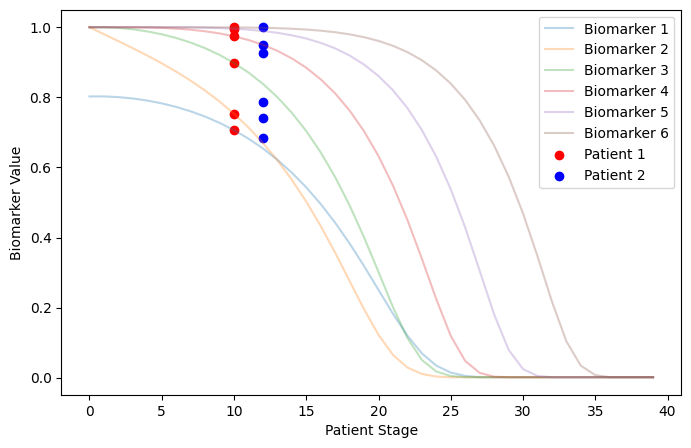

In [4]:
def generate_patient(stage, transition_matrix, y_init, add_noise=False, noise_std=0.1, random_state=None):
    """Generates vector of patient biomarkers given patient stage. Optionally adds Gaussian noise to biomarkers.
    
    Parameters:
    - stage: The stage of AD for the patient.
    - transition_matrix: The transition matrix used for simulating progression.
    - y_init: Initial biomarker values.
    - add_noise: If True, adds Gaussian noise to the biomarker values.
    - noise_std: Standard deviation of the Gaussian noise.
    - random_state: Seed for the random number generator for reproducibility.
    """
    y_stage = apply_transition_matrix2(transition_matrix, stage, y_init)  # Simulate progression to given stage
    if add_noise:
        random = np.random.RandomState(random_state)
        noise = random.normal(0, noise_std, y_stage.size)
        y_stage += noise
    y_stage = np.clip(y_stage, 0, 1)  # Ensure biomarker values are within [0, 1]
    return y_stage

stage_example1 = 10
stage_example2 = 12

transition_matrix = generate_transition_matrix(num_biomarkers, coeff)
y_init = initialize_biomarkers(num_biomarkers)
biomarkers_progressions = simulate_progression_over_stages2(transition_matrix, stages, y_init)

patient1 = generate_patient(stage_example1, transition_matrix, y_init, random_state=10)
patient2 = generate_patient(stage_example2, transition_matrix, y_init, add_noise=True, noise_std=0.1, random_state=10)

# Plotting for visualization
plt.figure(figsize=(8, 5))
for i in range(num_biomarkers):
    plt.plot(stages, biomarkers_progressions[:, i], label=f'Biomarker {i+1}', alpha=0.3) 
plt.scatter([stage_example1] * num_biomarkers, patient1, label='Patient 1', color='red')
plt.scatter([stage_example2] * num_biomarkers, patient2, label='Patient 2', color='blue')
plt.xlabel('Patient Stage')
plt.ylabel('Biomarker Value')
plt.legend()
plt.show()


In [5]:
class Graph():
 
    def __init__(self, vertices):
        self.V = vertices
        self.graph = [[0 for column in range(vertices)]
                      for row in range(vertices)]
 
    def printSolution(self, dist):
        print("Vertex \tDistance from Source")
        for node in range(self.V):
            print(node, "\t", dist[node])
 
    # A utility function to find the vertex with minimum distance value, from the set of vertices
    def minDistance(self, dist, sptSet):
        min = sys.maxsize
        for u in range(self.V):
            if dist[u] < min and sptSet[u] == False:
                min = dist[u]
                min_index = u
        return min_index
 
    # Function that implements Dijkstra's single source shortest path algorithm for a graph represented
    def dijkstra(self, src):
 
        dist = [sys.maxsize] * self.V
        dist[src] = 0
        sptSet = [False] * self.V
 
        for cout in range(self.V):
            x = self.minDistance(dist, sptSet)
            sptSet[x] = True
            for y in range(self.V):
                if self.graph[x][y] > 0 and sptSet[y] == False and \
                        dist[y] > dist[x] + self.graph[x][y]:
                    dist[y] = dist[x] + self.graph[x][y]
 
        return dist
 
# This code is contributed by Divyanshu Mehta and Updated by Pranav Singh Sambyal

def compute_log_prior_from_adjacency(A, _lambda = 1.0): # lambda is a reserved token!
    g = Graph(np.shape(A)[0])

    L = A.copy()
    L[L==0.0] = -1.0
    L = 1/L
    L[L<0.0] = 0.0

    g.graph = L
    log_prior = np.full(np.shape(A),0.0) #Only for tri-diagnoal A with constant off-diagnoal a

    for i in range(np.shape(A)[0]):
        dist = np.asarray(g.dijkstra(i))
    #     dist[dist == 0] = -1.0
        log_prior[:,i] = -1.0*dist

    # log_prior[log_prior > 0.0] = 0.0
    return log_prior * _lambda

# Simulations


Keep in mind that for now we model a "canonical order" as a order of shifts, e.g. if biomarker $i$ has shift $5$ and biomarker $j$ has shift $10$, then in "canonical order" $i$ preceeds $j$. However, given different (possibly randomly generated values of shifts and slopes), some biomarker might have smaller shift, but degrade much faster after 50% threshold.

See example below, biomarker 2 starts degradion later than biomarker 1, but much faster.

## Generate biomarker parameters

In [6]:
num_biomarkers = 11
A = generate_transition_matrix(size=num_biomarkers, coeff=1e-1)
A = A[1:, 1:]  # remove the first row and first column

prior = compute_log_prior_from_adjacency(A)
#prior = prior[1:, 1:]  # adjusting the prior matrix similarly
np.shape(prior)

y_init = initialize_biomarkers(num_biomarkers, init_value=0.9)
y_init = y_init[1:]  # remove the first element
y_init[0] = 0.9  # remove the first element

biomarkers_params = {
    'transition_matrix': A,
    'y_init': y_init
}

biomarkers_params

{'transition_matrix': array([[1. , 0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0.1, 1. , 0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0.1, 1. , 0.1, 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0.1, 1. , 0.1, 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0.1, 1. , 0.1, 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0.1, 1. , 0.1, 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0.1, 1. , 0.1, 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0.1, 1. , 0.1, 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1, 1. , 0.1],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1, 1. ]], dtype=float32),
 'y_init': array([0.9, 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ], dtype=float32)}

## Generate patient distribution (by stage)

How many patients will be at stage $x$

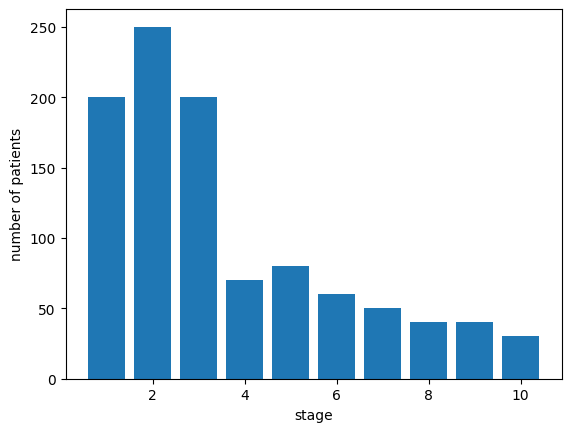

In [7]:
n_patients_stage = {
    1: 200,
    2: 250,
    3: 200,
    4: 70,
    5: 80,
    6: 60,
    7: 50,
    8: 40,
    9: 40,
    10: 30,
}

plt.bar(n_patients_stage.keys(), n_patients_stage.values());
plt.xlabel('stage')
plt.ylabel('number of patients');
plt.show()

## Generate biomarkers

In [8]:
X = []  # Biomarker data for all patients
rs = 10  # Starting random state for variability in patient data
stage_factor = 5

for stage, total_number in n_patients_stage.items():
    for _ in range(total_number):
        patient_biomarkers = generate_patient(stage*stage_factor, biomarkers_params['transition_matrix'], biomarkers_params['y_init'], add_noise=True, noise_std=0.5, random_state=rs)
        X.append(patient_biomarkers)
        rs += 1

X = np.array(X)

# Define health status based on stage: stages 1-3 are considered healthy, >3 are diseased
n_healthy = sum(n_patients_stage[stage] for stage in range(1, 4))
n_diseased = sum(n_patients_stage.values()) - n_healthy
y = np.array([0] * n_healthy + [1] * n_diseased)


In [9]:
biomarkers_params['transition_matrix'], biomarkers_params['y_init']

(array([[1. , 0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0.1, 1. , 0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0.1, 1. , 0.1, 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0.1, 1. , 0.1, 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0.1, 1. , 0.1, 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0.1, 1. , 0.1, 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0.1, 1. , 0.1, 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0.1, 1. , 0.1, 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1, 1. , 0.1],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1, 1. ]], dtype=float32),
 array([0.9, 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ], dtype=float32))

In [10]:
X.shape, y.shape

((1020, 10), (1020,))

In [11]:
stages = []

for k,v in n_patients_stage.items():
    stages.extend([k]*v)
stages = np.array(stages)

stages

array([ 1,  1,  1, ..., 10, 10, 10])

In [12]:
stages[150]

1

 Recall how even though stage is 1, on OX axis it apears as 3, this is due to shift for biomarker 0 being 6, see biomarkers_params dict, one could imporve this alignment, by generating sigmoids parameters in some systematic  non random way

In [13]:
biomarkers_params

{'transition_matrix': array([[1. , 0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0.1, 1. , 0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0.1, 1. , 0.1, 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0.1, 1. , 0.1, 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0.1, 1. , 0.1, 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0.1, 1. , 0.1, 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0.1, 1. , 0.1, 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0.1, 1. , 0.1, 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1, 1. , 0.1],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1, 1. ]], dtype=float32),
 'y_init': array([0.9, 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ], dtype=float32)}

## Check biomarker's distribution

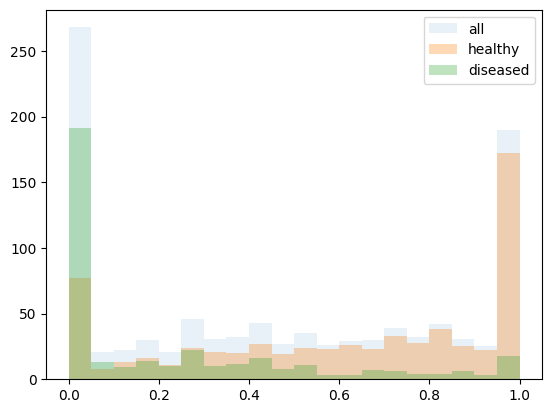

In [14]:
biomarker = 0

bins = plt.hist(X[:, biomarker], alpha=0.1, label='all', bins=20);
plt.hist(X[:n_healthy, biomarker], label='healthy', bins=bins[1], alpha=0.3);
plt.hist(X[n_healthy:, biomarker], label='diseased', bins=bins[1], alpha=0.3);
plt.legend();

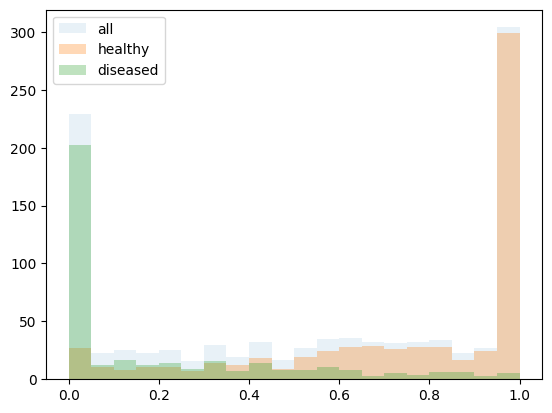

In [15]:
biomarker = 2

bins = plt.hist(X[:, biomarker], alpha=0.1, label='all', bins=20);
plt.hist(X[:n_healthy, biomarker], label='healthy', bins=bins[1], alpha=0.3);
plt.hist(X[n_healthy:, biomarker], label='diseased', bins=bins[1], alpha=0.3);
plt.legend();

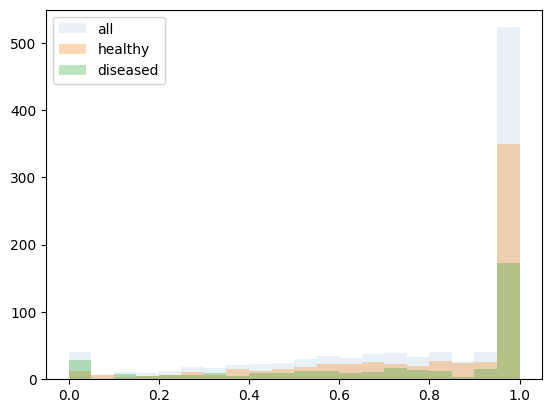

In [16]:
biomarker = 9

bins = plt.hist(X[:, biomarker], alpha=0.1, label='all', bins=20);
plt.hist(X[:n_healthy, biomarker], label='healthy', bins=bins[1], alpha=0.3);
plt.hist(X[n_healthy:, biomarker], label='diseased', bins=bins[1], alpha=0.3);
plt.legend();

In [17]:
X.shape

(1020, 10)

In [18]:
len(y)

1020

## EBM fit

install https://github.com/kurmukovai/ebm-progression by cloning the repo and `pip install -e .`

In [19]:
from ebm.probability import log_distributions, fit_distributions
from ebm.mcmc import greedy_ascent, mcmc
from ebm.likelihood import EventProbabilities

In [21]:
log_p_e, log_p_not_e = log_distributions(X, y, point_proba=False)
starting_order = np.arange(10) # just to make optimization procedure do the job, since data where generated with canonical order 0..10
np.random.shuffle(starting_order) 

[0 1 2 3 4 5 6 7 8 9]
[8 3 6 7 5 2 1 0 9 4]


In [ ]:
print(starting_order)

In [ ]:
order, loglike, update_iters = greedy_ascent(log_p_e, log_p_not_e, 
                                             n_iter=10_000, order = starting_order.copy(),
                                             random_state=2020)

In [ ]:
prior_order, prior_loglike, prior_update_iters = greedy_ascent(log_p_e, log_p_not_e, 
                                             n_iter=10_000, order = starting_order.copy(),
                                             random_state=2020, prior = prior)


In [ ]:
# order after burn in without log_priors
order

In [ ]:
# order after burn in with log_priors
prior_order

In [ ]:
plt.plot(loglike)

In [ ]:
plt.plot(prior_loglike)

In [ ]:
orders, loglike, update_iters, probas = mcmc(log_p_e, log_p_not_e,
                                                 order=order, n_iter=500_000,
                                                 random_state=2020)

In [ ]:
prior_orders, prior_loglike, prior_update_iters, prior_probas = mcmc(log_p_e, log_p_not_e,
                                                 order=prior_order, n_iter=500_000,
                                                 random_state=2020, prior = prior)

In [ ]:
orders[:10]
print(len(orders))

In [ ]:
prior_orders[:10]
print(len(prior_orders))

In [ ]:
# 3. Compute spearman's rank correlation between true (1,2,3..10) and mcmc-optimal order
# 4. Compare spearman's rho for when using and when not using prior

from scipy.stats import spearmanr

true_order = np.arange(num_biomarkers-1)  # true order for 'orders'
mean_rho = 0

for i in range(len(orders)):
        rho_orders, _ = spearmanr(true_order, orders[i])
        mean_rho += rho_orders
mean_rho = mean_rho/len(orders)
print(f"Spearman's rho of MCMC order without prior: {mean_rho}")

print(len(prior_orders))

prior_mean_rho = 0
for i in range(len(prior_orders)):
        prior_rho_orders, _ = spearmanr(true_order, prior_orders[i])
        prior_mean_rho += prior_rho_orders
prior_mean_rho = prior_mean_rho/len(prior_orders)
print(f"Spearman's rho of MCMC order without prior: {prior_mean_rho}")

In [ ]:
# 6. Make a graph of spearman's rho vs. value of lambda (vary lambda over large magnitude ranges, e.g. from 10^-5 to 10^5)

lambda_values = np.logspace(-5, 5, num=20)
spearman_rhos = []

for lambda_value in lambda_values:
    scaled_log_prior = compute_log_prior_from_adjacency(A, lambda_value)

    prior_orders2, prior_loglike2, prior_update_iters2, prior_probas2 = mcmc(log_p_e, log_p_not_e,
                                                 order=prior_order, n_iter=100_000,
                                                 random_state=2020, prior = scaled_log_prior)
    
    
    try:
        rho_prior_orders, _ = spearmanr(true_order, prior_orders2[0])
    except:
        pass
    spearman_rhos.append(rho_prior_orders)

# plotting
plt.figure(figsize=(10, 6))
plt.semilogx(lambda_values, spearman_rhos, marker='o', linestyle='-', color='blue')
plt.xlabel('Lambda (λ)')
plt.ylabel("Spearman's Rho")
plt.title("Spearman's Rho vs. Lambda (λ) for MCMC-derived Biomarker Orders")
plt.grid(True)
plt.show()

## Optimal order

For relatively small number of biomarkers, one could find an optimal order given the data (by computing all possible permutations). For 11 biomarkers, there are 11! = $39916800$ possible orders, so my implementation computing the total likelihood from Fontejn et. al takes about an 1 hour. One could optimize, I believe optimal order (under EBM setting) could be computationally tractable for ~15 biomarkers (in under a 1 day of computing+we could compute likelihoods in parallel, may be pushing to 16-17 biomarkers).

In [ ]:
from tqdm import tqdm

In [ ]:
model = EventProbabilities(log_p_e, log_p_not_e)
loglike = model.compute_total_likelihood(order)

In [ ]:
import itertools
all_orders = list(itertools.permutations(np.arange(11)))

In [ ]:
np.argmax(loglike)

In [ ]:
all_orders[np.argmax(loglike)]

In [ ]:
orders[np.argmax(loglike)]

In [ ]:
prior_orders[np.argmax(prior_loglike)]

In [ ]:
for i,o in enumerate(all_orders):
    if o == (1,  0,  2,  3,  5,  6,  4,  7,  8,  9, 10):
        print(i)
        break

In [ ]:
loglikes[3629640]

In [ ]:
loglikes[0]

In [ ]:
np.min(loglikes)

In [ ]:
random = np.random.RandomState(10)

shift = random.randint(5, 7, 11)
shift = np.cumsum(shift)
vel = random.randint(2, 15, 11)

x = np.linspace(-50, 120, 1000)
for s, v in zip(shift, vel):
    yy = sigmoid_inv(x, s, v)
    plt.plot(x, yy, alpha=0.1, c='b')
    
yy = sigmoid_inv(x, shift[4], vel[4], )
plt.plot(x, yy, alpha=0.7, c='b', label='biomarker 4')
yy = sigmoid_inv(x, shift[0], vel[0], )

plt.plot(x, yy, alpha=0.7, c='r', label='biomarker 0')


plt.legend();

TODO: 

1. Добавить кластеры сабджектов
2. Придумать модель которая умеет такое фитить
3. Сделать принадлежность кластеру функцией от каких-то клинических переменных
 - MOCA
 - MMSE
 - UPDRS
 
 т.е условно скоры по MOCA определяет то в какой кластер деградации попадает пациент
 

одна группа маркеров которая генерит центры кластеров по клиническим переменным, потом в зависимости от кластера 
разные параметры сигмоид, 

модель для определения кластера может быть supervised 